In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
np.random.seed(42)
# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# ensembles 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor

### Data Exploration

In [2]:
# getting the data
df = pd.read_csv('data/Unified-class.csv');
df.columns = [x.lower() for x in df.columns] # lowercase the columns
df.head()

id   type                           name  \
0   L70222  Class                     BindingKey   
1   L57358  Class             BufferChangedEvent   
2  L117505  Class           CheckDebugAttributes   
3   L66611  Class  ClasspathContainerInitializer   
4  L130930  Class   ClasspathVariableInitializer   

                                            longname  parent component  \
0                    org.eclipse.jdt.core.BindingKey  L92879      L103   
1            org.eclipse.jdt.core.BufferChangedEvent  L92879      L103   
2          org.eclipse.jdt.core.CheckDebugAttributes  L92879      L103   
3  org.eclipse.jdt.core.ClasspathContainerInitial...  L92879      L103   
4  org.eclipse.jdt.core.ClasspathVariableInitializer  L92879      L103   

                                                path  line  column  endline  \
0  org.eclipse.jdt.core/model/org/eclipse/jdt/cor...    25       1      267   
1  org.eclipse.jdt.core/model/org/eclipse/jdt/cor...    47       1      117   
2  org.eclipse.jdt.core/antadapter/org/eclipse/jd...    40       1       98   
3  org.eclipse.jdt.core/model/org/eclipse/jdt/cor...    44       1      366   
4  org.eclipse.jdt.core/model/org/eclipse/jdt/cor...    26       1       52   

   ...  tnlm  tnlpa  tnlpm  tnls  tnm  tnos  tnpa  tnpm  tns  bug  
0  ...    13      0     13     0   13    49     0    13    0    0  
1  ...     5      0      5     0    5     8     0     5    0    0  
2  ...     4      0      3     2    4    33     0     3    2    0  
3  ...    15      2     15     0   15    21     5    15    0    0  
4  ...     2      0      2     0    2     0     0     2    0    0  

[5 rows x 72 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47618 entries, 0 to 47617
Data columns (total 72 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         47618 non-null  object 
 1   type       47618 non-null  object 
 2   name       47618 non-null  object 
 3   longname   47618 non-null  object 
 4   parent     47618 non-null  object 
 5   component  47618 non-null  object 
 6   path       47618 non-null  object 
 7   line       47618 non-null  int64  
 8   column     47618 non-null  int64  
 9   endline    47618 non-null  int64  
 10  endcolumn  47618 non-null  int64  
 11  cc         47618 non-null  float64
 12  ccl        47618 non-null  int64  
 13  cco        47618 non-null  int64  
 14  ci         47618 non-null  int64  
 15  clc        47618 non-null  float64
 16  cllc       47618 non-null  float64
 17  ldc        47618 non-null  int64  
 18  lldc       47618 non-null  int64  
 19  lcom5      47618 non-null  int64  
 20  nl    

**The features has no missing values**

In [4]:
# getting the number of unique values per 'object' features
for col in df.columns:
  if df[col].dtype == 'O':
    print(col, ": ", df[col].nunique())

id :  35887
type :  4
name :  36474
longname :  38151
parent :  10609
component :  1
path :  26057


**We will drop all the 'object' features except the `type` feature as they have a huge number of unique values**

In [5]:
# drop object features except type 
df.drop(np.r_[['id'], df.columns[2:7]], axis=1, inplace=True)

In [6]:
# max and min values in the target class
df['bug'].unique().max(), df['bug'].unique().min()

(62, 0)

**The max target value is 62 and the min target value is 0**

#### One-hot-encoding the `type` feature 

In [7]:
df['type'].unique()

array(['Class', 'Interface', 'Annotation', 'Enum'], dtype=object)

In [8]:
# one-hot-encoding the type feature
type_dummies = pd.get_dummies(df['type'])
df = pd.concat([df, type_dummies], axis=1)
df.drop('type', axis=1, inplace=True)
df.head()

line  column  endline  endcolumn   cc  ccl  cco  ci  clc  cllc  ...  tnm  \
0    25       1      267          2  0.0    0    0   0  0.0   0.0  ...   13   
1    47       1      117          2  0.0    0    0   0  0.0   0.0  ...    5   
2    40       1       98          2  0.0    0    0   0  0.0   0.0  ...    4   
3    44       1      366          2  0.0    0    0   0  0.0   0.0  ...   15   
4    26       1       52          2  0.0    0    0   0  0.0   0.0  ...    2   

   tnos  tnpa  tnpm  tns  bug  Annotation  Class  Enum  Interface  
0    49     0    13    0    0           0      1     0          0  
1     8     0     5    0    0           0      1     0          0  
2    33     0     3    2    0           0      1     0          0  
3    21     5    15    0    0           0      1     0          0  
4     0     0     2    0    0           0      1     0          0  

[5 rows x 69 columns]

In [9]:
# Splitting the dataframe into features and target
columns = list(df.columns)
columns.remove('bug')
x,y = df[columns] , df['bug']

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)
(x_train.shape, y_train.shape), (x_valid.shape, y_valid.shape)

(((38094, 68), (38094,)), ((9524, 68), (9524,)))

In [11]:
# calculates the rmse between the predictions and actual values
def rmse_score(y_pred, y):
    return np.sqrt(mean_squared_error(y_pred, y))

# gets the predictions using x and the estimator and then calculates rmse between the predictions and y
def rmse_scorer(estimator, x, y):
    y_pred = estimator.predict(x)
    return rmse_score(y_pred,y)

In [21]:
# fit_model
# takes a model and datasets as input and outputs the scores
def fit_model(model, x_train, y_train, x_valid, y_valid):
  # fitting the model
  model.fit(x_train, y_train)
  
  # making prediction on the valid data
  preds = model.predict(x_valid)
  # calculating the scores
  rmse_train = rmse_score(y_train, model.predict(x_train))
  mse = mean_squared_error(y_valid, preds)
  rmse = rmse_score(y_valid, preds)
  r2 = r2_score(y_valid, preds) 

  print(f"Train RMSE: {rmse_train:.3f} | RMSE: {rmse:.3f} | MSE: {mse:.3f} | R2  : {r2:.3f}")
  return model

In [22]:
# pipeline to scale and then train a random forest
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

pipeline = fit_model(pipeline, x_train, y_train, x_valid, y_valid)

Train RMSE: 0.454 | RMSE: 1.059 | MSE: 1.121 | R2  : 0.181


### Outlier Detection

In [23]:
# taking a copy of the dataframe
no_outliers_df = df.copy()
x,y = no_outliers_df[columns] , no_outliers_df['bug']

In [24]:
# detecting outliers using IsolationForest
outlierDetector =  IsolationForest(n_estimators=100,random_state = 42)
result = outlierDetector.fit_predict(x)
outliers = no_outliers_df[result==-1]

In [25]:
# drop outliers
no_outliers_df = no_outliers_df.drop(outliers.index)
print(f'Number of removed outliers {outliers.index.shape[0]}')

Number of removed outliers 2818


In [26]:
# splitting the new data into train and validation
x,y = no_outliers_df[columns] , no_outliers_df['bug']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)
(x_train.shape, y_train.shape), (x_valid.shape, y_valid.shape)

(((35840, 68), (35840,)), ((8960, 68), (8960,)))

In [27]:
# refitting the pipeline after removing the outliers
pipeline = fit_model(pipeline, x_train, y_train, x_valid, y_valid)

Train RMSE: 0.324 | RMSE: 0.837 | MSE: 0.700 | R2  : 0.133


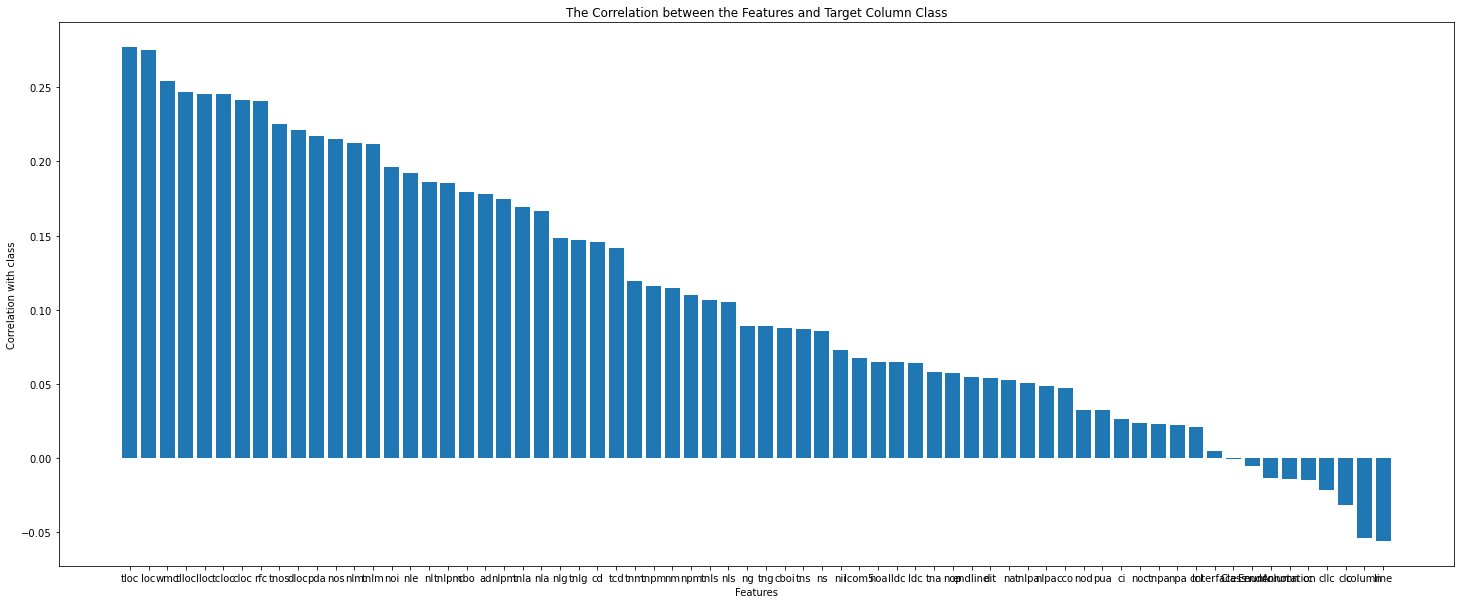

In [28]:
# correlation 
corr = pd.DataFrame(no_outliers_df.corr()['bug'].sort_values(ascending=False)[1:])

labels = corr.index
corr_values = corr['bug'].tolist()

plt.figure(figsize=(25, 10))
plt.bar(labels, corr_values)
plt.xlabel('Features')
plt.ylabel('Correlation with class')
plt.title('The Correlation between the Features and Target Column Class')
plt.show()

In [29]:
# helper functions for RandomForests
# puts the feature importance of RandomForest in a DataFrame
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns[:-1], 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

# Plots the feature importance using the DataFrame
def plot_fi(fi, figsize=(12, 7)):
    return fi.plot('cols', 'imp', 'barh', figsize=figsize, legend=False)

In [30]:
# Find the features importance 
fi = rf_feat_importance(pipeline['rf'], no_outliers_df)
fi

cols       imp
28       tcloc  0.068038
0         line  0.048186
16         cbo  0.036930
2      endline  0.035687
35         loc  0.031252
..         ...       ...
3    endcolumn  0.001665
67        Enum  0.000291
65  Annotation  0.000235
64         bug  0.000030
66       Class  0.000005

[68 rows x 2 columns]

<AxesSubplot:ylabel='cols'>

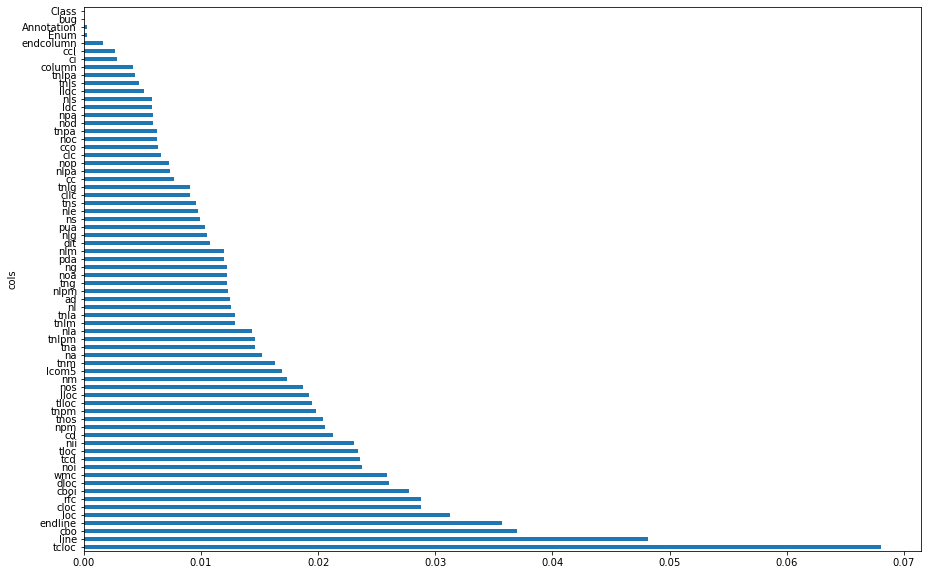

In [31]:
# Plot the features importance 
plot_fi(fi, figsize=(15, 10))

### PCA

In [32]:
# Printing the 
print(f'Number of features before PCA: {no_outliers_df.shape[1]}')

Number of features before PCA: 69


In [34]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('pca', PCA(n_components=.95, whiten=True, random_state=42)),
  ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

pipeline = fit_model(pipeline, x_train, y_train, x_valid, y_valid)

Train RMSE: 0.330 | RMSE: 0.850 | MSE: 0.723 | R2  : 0.104


In [35]:
pipeline['pca'].n_components_

27

In [36]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('pca', PCA(n_components=.97, whiten=True)),
  ('rf', RandomForestRegressor(random_state=42))
])

pipeline = fit_model(pipeline, x_train, y_train, x_valid, y_valid)

Train RMSE: 0.330 | RMSE: 0.850 | MSE: 0.722 | R2  : 0.106


In [37]:
pipeline['pca'].n_components_

31

### Training individual models

In [55]:
# RF
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('pca', PCA(n_components=.95, whiten=True, random_state=42)),
  ('random_rf', RandomizedSearchCV(estimator = RandomForestRegressor(random_state=42, n_jobs=-1), param_distributions = param_grid, 
                n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1))
])

rf_pipeline = fit_model(rf_pipeline, x_train, y_train, x_valid, y_valid)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.3min finished


Train RMSE: 0.699 | RMSE: 0.835 | MSE: 0.698 | R2  : 0.135


In [57]:
rf_pipeline['random_rf'].best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 9,
 'bootstrap': False}

In [52]:
# KNN
param_grid = {'n_neighbors':[4,5,6,7],
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree']}

knn_pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('pca', PCA(n_components=.95, whiten=True)),
  ('random_knn', RandomizedSearchCV(estimator = KNeighborsRegressor(n_jobs=-1), param_distributions = param_grid, 
                               n_iter = 24, cv = 3, verbose=2, random_state=42, n_jobs = -1))
])


knn_pipeline = fit_model(knn_pipeline, x_train, y_train, x_valid, y_valid)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.9min finished


Train RMSE: 0.696 | RMSE: 0.830 | MSE: 0.689 | R2  : 0.146


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, whiten=True)),
                ('random_knn',
                 RandomizedSearchCV(cv=3,
                                    estimator=KNeighborsRegressor(n_jobs=-1),
                                    n_iter=24, n_jobs=-1,
                                    param_distributions={'algorithm': ['auto',
                                                                       'kd_tree'],
                                                         'leaf_size': [1, 3, 5],
                                                         'n_neighbors': [4, 5,
                                                                         6,
                                                                         7]},
                                    random_state=42, verbose=2))])

In [59]:
knn_pipeline['random_knn'].best_params_

{'n_neighbors': 7, 'leaf_size': 3, 'algorithm': 'auto'}

### Ensembles 

In [81]:
# the best parameters
rf = RandomForestRegressor(**rf_pipeline['random_rf'].best_params_, random_state=42, n_jobs=-1)
knn = KNeighborsRegressor(**knn_pipeline['random_knn'].best_params_, n_jobs=-1)

print('-'*5, 'Models Scores', '-'*5)
print('RF : ', rmse_scorer(rf_pipeline, x_valid, y_valid))
print('KNN: ', rmse_scorer(knn_pipeline, x_valid, y_valid))

----- Models Scores -----
RF :  0.835269866314049
KNN:  0.8301719675024098


In [84]:
# ensemble
voting_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('voter', VotingRegressor(estimators=[('RF', rf), ('KNN', knn)], n_jobs=-1, verbose=2))
])


voting__pipeline = fit_model(voting_pipeline, x_train, y_train, x_valid, y_valid)

Train RMSE: 0.681 | RMSE: 0.818 | MSE: 0.669 | R2  : 0.171


### Bagging and Pasting using the Best Model

In [100]:
# instead of all the next cells but will take lots of time :(
# bagging_bootsrap_params = {
#     'oob_score': [True, False],
#     'max_samples': [0.5, 0.7, 0.8],
#     'n_estimators': [10, 20, 30]
# }

# bag_search = Pipeline([
#     ('scaler', StandardScaler()),
#     ('pca', PCA(n_components=0.95, whiten=True)),
#     ('search', GridSearchCV(BaggingRegressor(knn, random_state=42, n_jobs=-1, verbose=2, bootstrap=True),
#                             param_grid=bagging_bootsrap_params, n_jobs=-1, cv=3))
# ])

# bag_search.fit(x_train, y_train)

In [89]:
bag_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('bag', BaggingRegressor(knn, max_samples=.75, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True, verbose=2))
])

bag_pipeline = fit_model(bag_pipeline, x_train, y_train, x_valid, y_valid)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:1066: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   19.3s remaining:   32.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   27.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | el

Train RMSE: 0.718 | RMSE: 0.823 | MSE: 0.678 | R2  : 0.160


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.7min finished


In [90]:
bag_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('bag', BaggingRegressor(knn, max_samples=.75, n_estimators=20, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True, verbose=2))
])

bag_pipeline = fit_model(bag_pipeline, x_train, y_train, x_valid, y_valid)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   40.9s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   51.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   51.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.6min remaining:  4.3min


Train RMSE: 0.716 | RMSE: 0.824 | MSE: 0.679 | R2  : 0.159


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.2min finished


In [94]:
bag_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('bag', BaggingRegressor(knn, max_samples=.75, n_estimators=30, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True, verbose=2))
])

bag_pipeline = fit_model(bag_pipeline, x_train, y_train, x_valid, y_valid)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.4s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.2min remaining:  2.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  4.7min remaining:  7.8min


Train RMSE: 0.714 | RMSE: 0.824 | MSE: 0.679 | R2  : 0.158


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  4.7min finished


In [95]:
bag_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('bag', BaggingRegressor(knn, max_samples=.75, n_estimators=20, random_state=42, n_jobs=-1, verbose=2))
])

bag_pipeline = fit_model(bag_pipeline, x_train, y_train, x_valid, y_valid)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   39.6s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   49.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   49.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  2.5min remaining:  4.2min


Train RMSE: 0.716 | RMSE: 0.824 | MSE: 0.679 | R2  : 0.159


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.2min finished


In [96]:
bag_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('bag', BaggingRegressor(knn, max_samples=.75, n_estimators=30, random_state=42, n_jobs=-1, verbose=2))
])

bag_pipeline = fit_model(bag_pipeline, x_train, y_train, x_valid, y_valid)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.4s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.2min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  4.6min remaining:  7.7min


Train RMSE: 0.714 | RMSE: 0.824 | MSE: 0.679 | R2  : 0.158


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  4.7min finished
